In [1]:
import networkx as nx
from networkx.generators.random_graphs import _random_subset
import sympy as sp
from sympy import symbols 
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sympy.utilities.lambdify import lambdify


import copy
import time
import random as rd

graph = "BA.adjlist"
# graph = "ER.adjlist"
# graph = "CO.adjlist"

eigen = "BA-pS.txt"
# eigen = "ER-pS.txt"
# eigen = "CO-pS.txt"

## Creazione del grafo

In [2]:
G = nx.read_adjlist(graph)

nodes = sorted([int(n) for n in G.nodes])

In [3]:
N = len(G.nodes)

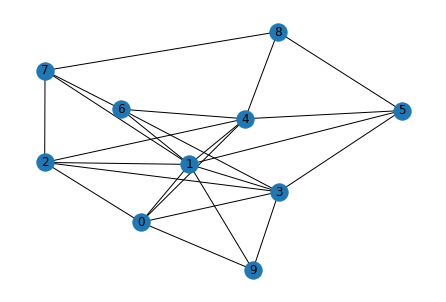

In [4]:
nx.draw(G, with_labels=True)    
plt.show()

In [5]:
adjacency = list(G.adjacency())

In [6]:
A = []
for a, b in adjacency :
    A += [[0]*len(adjacency)]

for a, b in adjacency :
    a = int(a)
    for c in b :
        c = int(c)
        A[a][c] = 1

Dinamica prima della rottura di un link

In [7]:
seed = np.random.RandomState()
def dynamic_evolution(G, history = []):
    evolution = [0] * len(G.nodes)
    for n in G.nodes:
        for i in range(G.nodes[n]['N_i']):
            neighbours = list(G[n])
            new_node = _random_subset(neighbours, 1, seed).pop()
            evolution[int(new_node)] += 1
    for n in G.nodes:
        G.nodes[n]['N_i'] = evolution[int(n)]
    history += [evolution]

In [8]:
walker_per_node = int(1e2)

In [9]:
long_history = [[]]
for h in range(len(long_history)):
    long_history[h] = [[walker_per_node] * len(G.nodes)]

In [10]:
time_steps = int(5e1)

In [11]:
t0 = time.time()

for h in range(len(long_history)):
    for n in G.nodes:
        G.nodes[n]['N_i'] = walker_per_node
    
    for t in range(time_steps):
        dynamic_evolution(G, long_history[h])

print(f"done in {int((time.time()-t0)/60)} minutes and {((time.time()-t0)%60)} seconds")

done in 0 minutes and 30.023053646087646 seconds


## Rimozione di un link

In [12]:
index = []
for i in range(N):
    for j in range(i+1, N):
        if A[i][j] == 1:
            index += [(i,j)]

removed_link = index[rd.randint(0, len(index)-1)]
links = len(index) - 1

G.remove_edge(str(removed_link[0]), str(removed_link[1]))

In [13]:
print("It was removed the link between node", removed_link[0], "and node", removed_link[1])

It was removed the link between node 5 and node 8


In [14]:
A[removed_link[0]][removed_link[1]] = 0
A[removed_link[1]][removed_link[0]] = 0

Calcolare autovalori e autovettori del nuovo grafo dopo la rottura di un link

In [15]:
adjacency = list(G.adjacency())
A = []
for a, b in adjacency :
    A += [[0]*len(adjacency)]

for a, b in adjacency :
    a = int(a)
    for c in b :
        c = int(c)
        A[a][c] = 1
        
P = []
for a, b in adjacency :
    P += [[0]*len(adjacency)]
    
for a, b in adjacency :
    a = int(a)
    for c in b: 
        c = int(c)
        P[a][c] = 1./G.degree[str(a)]

matrixP = np.array(P)
autovaloriP, autovettoriP = np.linalg.eig(np.transpose(matrixP))
autovettoriP = np.transpose(autovettoriP)

diff = [np.abs(autovaloriP[i] - 1) for i in range(N)]
minDiff = min(diff)
for i in range(N):
    if np.abs(autovaloriP[i] - 1) == minDiff:
        pS2 = autovettoriP[i]
        print("Eigenvector found")
        break

if pS2[0] < 0:
    pS2 = -pS2

print('Autovalori di P:', autovaloriP)

matrixL = np.identity(N) - matrixP

autovaloriL, autovettoriL = np.linalg.eig(np.transpose(matrixL))
autovettoriL = np.transpose(autovettoriL)

diff = [np.abs(autovaloriL[i]) for i in range(N)]
minDiff = min(diff)
for i in range(N):
    if np.abs(autovaloriL[i]) == minDiff:
        pS2_L = autovettoriL[i]
        print("Eigenvector found")
        break

if pS2_L[0] < 0:
    pS2_L = -pS2_L

print('Autovalori di L:', autovaloriL)

Eigenvector found
Autovalori di P: [ 1.00000000e+00 -7.10250206e-01  4.46807447e-01 -4.44104280e-01
 -3.63536455e-01  1.65053850e-01  1.13641490e-01 -7.66163148e-02
 -1.30995530e-01 -3.74478404e-17]
Eigenvector found
Autovalori di L: [0.         1.71025021 0.55319255 1.36353646 1.44410428 0.83494615
 0.88635851 1.07661631 1.13099553 1.        ]


In [16]:
i = 13
print(np.round(pS2, i) == np.round(pS2_L, i))

pS2  = np.round(pS2.real, i)

[ True  True  True  True  True  True  True  True  True  True]


Dinamica dopo la rottura di un link

In [17]:
t0 = time.time()

for h in range(len(long_history)):    
    for t in range(time_steps):
        dynamic_evolution(G, long_history[h])

print(f"done in {int((time.time()-t0)/60)} minutes and {((time.time()-t0)%60)} seconds")

done in 0 minutes and 31.977158308029175 seconds


## Otimmizzazione dei pesi

In [18]:
W = symbols(f'w:{links}')
print("There are", links, "indipendent weights")

There are 23 indipendent weights


In [19]:
count = 0
P = copy.deepcopy(A)
for i in range(N):
    for j in range(i+1, N):
        if P[i][j] == 1:
            P[i][j] = W[count]
            P[j][i] = W[count]
            count += 1

2* L'autovettore stazionario non coincide

In [20]:
with open(eigen, "r") as file:
    pS = file.read()
    pS = pS.split("\n")
    
pS = [float(i) for i in pS[:-1]]
pS = np.round(pS, 5)

In [21]:
e = (np.dot(pS, P) - pS)**2
E = e[0]
for i in range(1, len(e)):
    E += e[i]

1* Aggiungere la normalizzazione dei pesi alla funzione di costo fa ottenere molti autovettori vicini a 1 e l'autovettore stazionario non coincide con il valore atteso.

In [22]:
t0 = time.time()

my_func = lambdify(W, E)

def my_func_v(x):
    return my_func(*tuple(x))

# def cons1(x, i):
#     C = (sum(P[i])-1)**2
#     func = lambdify(W, C)
#     return func(*tuple(x))

# cons = ([{'type' : 'eq', 'fun': lambda x: cons1(x, i)} for i in range(len(P))])

x0 = [1/links]*links
# solution = minimize(my_func_v, x0, bounds = [[0, np.inf]]*len(x0), constraints=cons).x
result = minimize(my_func_v, x0, bounds = [[0, np.inf]]*len(x0), tol = 1e-15)
solution = result.x

print(f"done in {int((time.time()-t0)/60)} minutes and {((time.time()-t0)%60)} seconds")

done in 0 minutes and 0.14855527877807617 seconds


In [23]:
count = 0
P_new = copy.deepcopy(A)
for i in range(N):
    for j in range(i+1, N):
        if P_new[i][j] == 1:
            P_new[i][j] = solution[count]
            P_new[j][i] = solution[count]
            count += 1

2* l'autovettore stazionario non coincide con quello atteso

Calcolo dei nuovi autovalori e autovettori dopo l'ottimizzazione

In [24]:
matrixP = np.array(P_new)

In [25]:
autovaloriP, autovettoriP = np.linalg.eig(np.transpose(matrixP))
autovettoriP = np.transpose(autovettoriP)

In [26]:
diff = [np.abs(autovaloriP[i] - 1) for i in range(N)]
minDiff = min(diff)
for i in range(N):
    if np.abs(autovaloriP[i] - 1) == minDiff:
        pS_new = autovettoriP[i]
        print("Eigenvector found")
        break

np.round(autovaloriP.real, 4)

Eigenvector found


array([ 1.000e+00, -6.289e-01,  3.530e-01, -4.268e-01, -2.388e-01,
       -2.029e-01, -5.270e-02,  1.126e-01,  8.450e-02,  1.000e-04])

In [27]:
if pS_new[0] < 0:
    pS_new = -pS_new

In [28]:
pS_new = pS_new.real

In [29]:
for i in range(4):
    print(sum(P_new[i]))

0.855330610471326
1.6925835445642121
0.8485291865164324
1.178048796482547


Dinamica dopo l'ottimizzazione dei pesi

In [30]:
seed = np.random.RandomState()
def dynamic_evolution_after(G, P_new, history = []):
    evolution = [0]*N
    for n in G.nodes:
        for i in range(G.nodes[n]['N_i']):
            neightbours = []
            n = int(n)
            for ind in range(len(P_new)):
                if P_new[n][ind] != 0:
                    if len(neightbours) != 0:
                        neightbours += [[ind, P_new[n][ind] + neightbours[-1][1]]]
                    else:
                        neightbours = [[ind, P_new[n][ind]]]
            s = sum(P_new[n])
            prob = rd.uniform(0., s)

            for neigh, p in neightbours:
                if prob <= p:
                    evolution[neigh] += 1
                    break
    for n in G.nodes:
        G.nodes[n]['N_i'] = evolution[int(n)]
    history += [evolution]

In [31]:
history = [[], [], []]
for h in range(len(history)):
    history[h] = [[walker_per_node] * len(G.nodes)]

In [32]:
t0 = time.time()

for h in range(len(long_history)):
    h = int(h)
    for t in range(time_steps):
        dynamic_evolution_after(G, P_new, long_history[h])

print(f"done in {int((time.time()-t0)/60)} minutes and {((time.time()-t0)%60)} seconds")

done in 0 minutes and 5.2474470138549805 seconds


In [33]:
time_steps = int(5e1)

In [34]:
t0 = time.time()

for h in range(len(history)):
    h = int(h)
    for n in G.nodes:
        G.nodes[n]['N_i'] = walker_per_node
    
    for t in range(time_steps):
        dynamic_evolution_after(G, P_new, history[h])

print(f"done in {int((time.time()-t0)/60)} minutes and {((time.time()-t0)%60)} seconds")

done in 0 minutes and 25.849818229675293 seconds


## Rappresentazione dei risultati

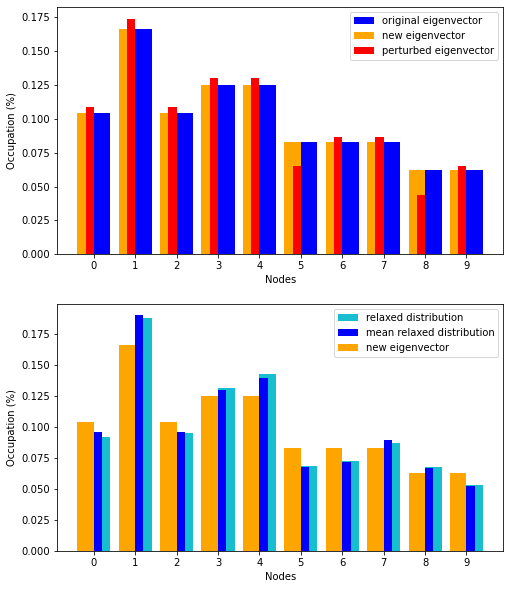

Solution found minimizing 10 equation in 23 variables


In [35]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(0.8*N, 10))

pSNorm = [h/sum(pS) for h in pS]
pS2Norm = [h/sum(pS2) for h in pS2]
pSNorm_new = [h/sum(abs(pS_new)) for h in pS_new]

ax[0].bar(nodes, pSNorm, width=0.4, align='edge', color='blue', label="original eigenvector")
ax[0].bar(nodes, pSNorm_new, width=-0.4, align='edge', color='orange', label="new eigenvector")
ax[0].bar(nodes, pS2Norm, width=-0.2, align='edge', color='red', label="perturbed eigenvector")

hMean = [[(h1+h2+h3)/walker_per_node/N/3 
          for h1, h2, h3 in zip(history[0][i], history[1][i], history[2][i])] 
         for i in range(len(history[0]))]

ax[1].bar(nodes, [h/sum(history[0][-1]) for h in history[0][-1]], width=0.4, 
          align='edge', color='tab:cyan', label='relaxed distribution')
ax[1].bar(nodes, hMean[-1], width=0.2, align='edge', color='blue', label='mean relaxed distribution')
ax[1].bar(nodes, pSNorm_new, width=-0.4, align='edge', color='orange', label="new eigenvector")

for i in [0,1]:
    ax[i].legend()
    ax[i].set_xlabel("Nodes")
    ax[i].set_ylabel("Occupation (%)")
    ax[i].set_xticks(np.arange(0, N, 1))
#     ax[i].grid(True)

plt.show()

print(f"Solution found minimizing {N} equation in {links} variables")

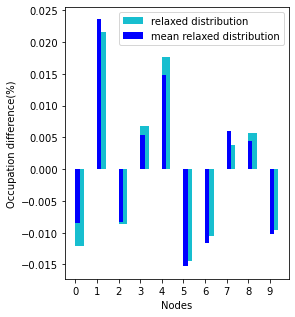

0.0021216577874741144


In [36]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(0.4*N, 5))

ax.bar(nodes, [h/sum(history[0][-1]) - k for h, k in zip(history[0][-1], pSNorm_new)], width=0.4, 
       align='edge', color='tab:cyan', label='relaxed distribution')
ax.bar(nodes, [h - k for h, k in zip(hMean[-1], pSNorm_new)],
       width=0.2, align='edge', color='blue', label='mean relaxed distribution')

ax.legend()
ax.set_xlabel("Nodes")
ax.set_ylabel("Occupation difference(%)")
ax.set_xticks(np.arange(0, N, 1))
# ax.grid(True)

plt.show()

print(sum([np.abs(h - k) for h, k in zip(hMean[-1], pSNorm_new)])/len(history[0]))

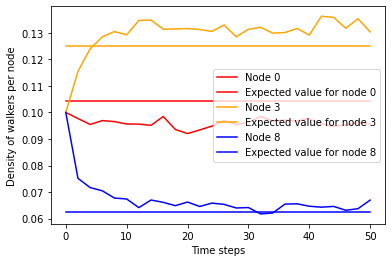

In [41]:
fig, ax = plt.subplots(nrows = 1, ncols = 1)
node = [0, 3, 8]
color = ['red', 'orange', 'blue', 'green']

time_range = hMean
index = np.arange(0, len(time_range), 2)

col = 0
for i in node:
    ax.plot(index, [time_range[ind][i] for ind in index], label = f"Node {i}", color = color[col])
    ax.plot(index, [pSNorm_new[i]]*len(index), label = f"Expected value for node {i}", color = color[col])
    col += 1
    
ax.set_xlabel("Time steps")
ax.set_ylabel("Density of walkers per node")
ax.legend()

plt.show()

## Evoluzione dinamica totale

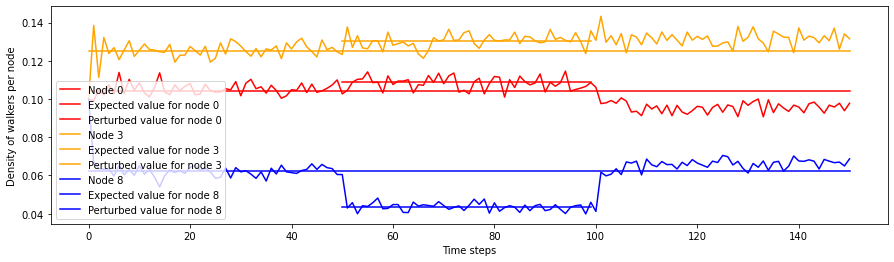

In [42]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(15, 4))
# node = nodes
color = ['red', 'orange', 'blue', 'green']

time_range = long_history[0]
index = np.arange(0, len(time_range), 1)
index2 = np.arange(time_steps, 2*time_steps, 1)

col = 0
for i in node:
    ax.plot(index, [time_range[ind][i]/walker_per_node/N for ind in index], label = f"Node {i}", color = color[col])
    ax.plot(index, [pSNorm[i]]*len(index), label = f"Expected value for node {i}", color = color[col])
    ax.plot(index2, [pS2Norm[i]]*len(index2), label = f"Perturbed value for node {i}", color = color[col])
    
#     index2 = np.arange(2*time_steps, 3*time_steps, 5)
#     ax.plot(index2, [time_range[ind][i]/walker_per_node/N for ind in index2], label = f"Node {i}", color = color[col])

    col += 1
    
ax.set_xlabel("Time steps")
ax.set_ylabel("Density of walkers per node")
ax.legend()

plt.show()